In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

In [9]:
raw_data = pd.read_csv("data/raw_data.txt", skiprows=5, encoding="latin-1", delimiter = "	", header=None, na_filter=True, usecols=list(range(1,10)))

In [10]:
raw_data

,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
507,0,0,0,0,0,0,0,0,0
508,0,0,0,0,0,0,0,0,0
509,0,0,0,0,0,0,0,0,0
510,0,0,0,0,0,0,0,0,0


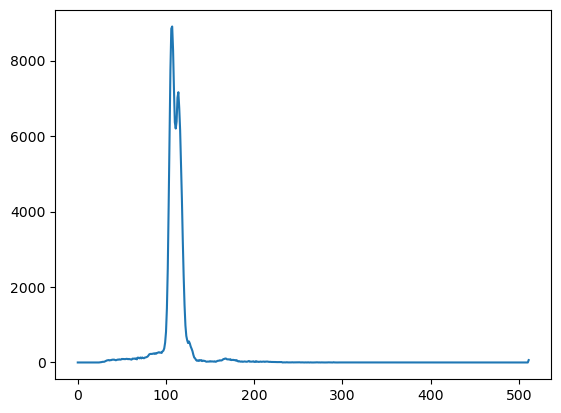

In [11]:
plt.plot(raw_data.iloc[:,7])
plt.show()

In [12]:
def callibration(n1,n2,E1,E2):
    m = (E2-E1)/(n2-n1)
    c = E2-m*n2
    return m, c

In [16]:
#function to find full width at half maximum (FWHM) of peak
def fwhm(x_values, y_values):
    # Find the maximum y-value and corresponding x-value
    max_y = max(y_values)
    max_x = x_values[y_values.index(max_y)]

    # Calculate half maximum
    half_max = max_y / 2

    # Find the indices of the points on either side of the peak where the y-value
    # crosses half maximum
    left_index = 0
    right_index = len(x_values) - 1
    for i in range(len(x_values)):
        if y_values[i] > half_max:
            left_index = i
            break
    for i in range(len(x_values) - 1, -1, -1):
        if y_values[i] > half_max:
            right_index = i
            break

    # Calculate the full width at half maximum
    fwhm = x_values[right_index] - x_values[left_index]

    return fwhm
#x_values = [1, 2, 3, 4, 5]
#y_values = [2, 4, 6, 4, 2]
#fwhm = fwhm(x_values, y_values)
#print(fwhm) # Output: 4
#plt.plot(x_values, y_values)



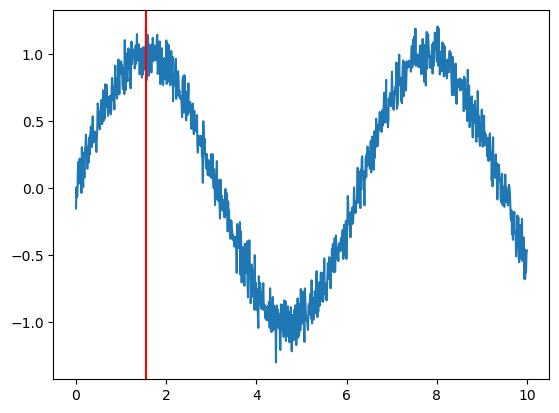

In [19]:
def find_peak(x, y, xmin, xmax):
    """
    Finds the maximum peak in a given range of x-values
    
    Arguments:
    x -- array of x-values
    y -- array of y-values
    xmin -- minimum x-value of range to search for peak
    xmax -- maximum x-value of range to search for peak
    
    Returns:
    x_peak -- x-value of peak
    y_peak -- y-value of peak
    """
    # Get indices corresponding to x-range
    ind_range = np.where(np.logical_and(x >= xmin, x <= xmax))
    
    # Get max y-value and its corresponding x-value in the range
    y_peak = np.max(y[ind_range])
    x_peak = x[ind_range][np.argmax(y[ind_range])]
    
    return x_peak, y_peak


# Generate example data
x = np.linspace(0, 10, 1000)
y = np.sin(x) + np.random.normal(0, 0.1, len(x))

# Plot data
plt.plot(x, y)

# Find peak between x=3 and x=6
xmin = 0
xmax = 4
x_peak, y_peak = find_peak(x, y, xmin, xmax)

# Plot peak as vertical line
plt.axvline(x=x_peak, color='r')

# Show plot
plt.show()



2.3858856552423573


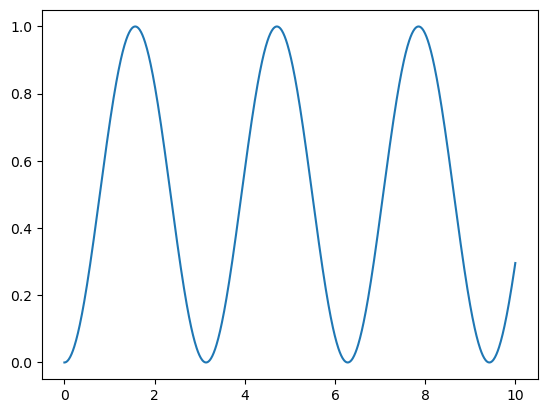

In [45]:
def count_rate(x, y, t):
    return sp.integrate.trapz(y, x)/t

count_rate = count_rate(x,y,2)
print(count_rate)
plt.plot(x,y)
plt.show()
